# DJF_PR_teleconnection: Structure of Boreal Winter Precipitation Anomalies

The "DJF_PR_teleconnection" notebook evaluates the relationship between ENSO (El Niño-Southern Oscillation) and boreal winter precipitation anomalies, focusing on the region between 60°S and 60°N. It analyses the spatial and temporal structure of precipitation patterns during the DJF period, providing insights into teleconnections and their potential impacts on global climate variability.

## Recommended Observational Datasets

### Temperature Surface (TS)

- **ERSSTv5**: The Extended Reconstructed Sea Surface Temperature version 5 (ERSSTv5) is a global monthly sea surface temperature dataset derived from in situ observations and optimally interpolated. It is widely used for climate studies and trend analysis.

- **HadISSTv1.1**: The Hadley Centre Sea Ice and Sea Surface Temperature dataset version 1.1 (HadISSTv1.1) provides a globally complete dataset of monthly mean sea surface temperatures and sea ice concentrations since 1870.

- **COBE2**: The Centennial In Situ Observation-Based Estimates version 2 (COBE2) provides high-resolution sea surface temperature data, constructed using historical ship-based observations and modern quality control techniques.

## Precipitation (PR)

- **GPCP**: The Global Precipitation Climatology Project (GPCP) dataset combines satellite and ground-based observations to produce global monthly precipitation estimates with near-global coverage since 1979.

- **CMAP**: The CPC Merged Analysis of Precipitation (CMAP) integrates satellite and gauge-based observations to estimate global precipitation, providing valuable insights into climate variability and hydrological processes.

## Dask Cluster 
Start a cluster with multiple cores

In [1]:
from dask.distributed import Client, progress
client = Client()
client

/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.6/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38601 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/38601/status,
Dashboard: /proxy/38601/status,Workers: 7
Total threads: 7,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42755,Workers: 7
Dashboard: /proxy/38601/status,Total threads: 7
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:38071,Total threads: 1
Dashboard: /proxy/34315/status,Memory: 4.57 GiB
Nanny: tcp://127.0.0.1:45607,


## Datasets

In [2]:
from esmvalcore.dataset import Dataset

In [3]:
model_ts_datasets = {
"ACCESS-ESM1-5": 
    Dataset(
    short_name='ts',
    project='CMIP6',
    mip="Amon",
    exp="historical",
    ensemble="r1i1p1f1",
    timerange="19790101/20190101",
    dataset="ACCESS-ESM1-5",
    grid="gn"
)}

model_pr_datasets = {
"ACCESS-ESM1-5": 
    Dataset(
    short_name='pr',
    project='CMIP6',
    mip="Amon",
    exp="historical",
    ensemble="r1i1p1f1",
    timerange="19790101/20150101",
    dataset="ACCESS-ESM1-5",
    grid="gn"
)}


obs_ts_datasets = {
"HadISST": 
    Dataset(
    short_name='ts',
    dataset='HadISST',
    mip="Amon",
    project='OBS',
    type='reanaly',
    tier=2),
# "ERSSTv5":
#     Dataset(
#     short_name='tos',
#     dataset='NOAA-ERSSTv5',
#     mip="Omon",
#     project='OBS6',
#     type='reanaly',
#     tier=2)
}

obs_pr_datasets = {
"GPCP-SG": 
    Dataset(
    short_name='pr',
    dataset='GPCP-SG',
    mip="Amon",
    project='OBS',
    type='atmos',
    tier=2),
# "CMAP": 
#     Dataset(
#     short_name='pr',
#     dataset='CMAP',
#     mip="Amon",
#     project='OBS6',
#     type='reanaly',
#     timerange="197901/202408",
#     tier=2)
}

## Add Ancillary files


In [4]:
for name, dataset in model_pr_datasets.items():
    dataset.add_supplementary(short_name='sftlf', mip="fx")
    dataset.add_supplementary(short_name="areacella", mip="fx")
for name, dataset in model_ts_datasets.items():
    dataset.add_supplementary(short_name='sftlf', mip="fx")
    dataset.add_supplementary(short_name="areacella", mip="fx")

In [5]:
model_ts_datasets = {name: dataset.load() for name, dataset in model_ts_datasets.items()}
model_pr_datasets = {name: dataset.load() for name, dataset in model_pr_datasets.items()}

obs_ts_datasets = {name: dataset.load() for name, dataset in obs_ts_datasets.items()}
obs_pr_datasets = {name: dataset.load() for name, dataset in obs_pr_datasets.items()}

(for file /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/fx/sftlf/gn/v20191115/sftlf_fx_ACCESS-ESM1-5_historical_r1i1p1f1_gn.nc)
(for file /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/fx/sftlf/gn/v20191115/sftlf_fx_ACCESS-ESM1-5_historical_r1i1p1f1_gn.nc)


In [6]:
from esmvalcore.preprocessor import anomalies
from esmvalcore.preprocessor import area_statistics
from esmvalcore.preprocessor import rolling_window_statistics
from esmvalcore.preprocessor import convert_units
from esmvalcore.preprocessor import extract_region
from esmvalcore.preprocessor import extract_season
from esmvalcore.preprocessor import extract_month
from esmvalcore.preprocessor import detrend
from esmvalcore.preprocessor import regrid
from esmvalcore.preprocessor import detrend
from esmvalcore.preprocessor import mask_landsea
from esmvalcore.preprocessor import extract_time
import iris

import matplotlib.pyplot as plt
import iris.quickplot as qplt
import numpy as np
import scipy.stats

In [7]:
def sst_enso(cube):
    nino34_latext_region = {"start_longitude": 190., "end_longitude": 240., "start_latitude": -5., "end_latitude": 5.}
    cube = extract_time(cube, start_year=1979, end_year=1981, start_month=1, end_month=12, start_day=1, end_day=31)
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = convert_units(cube, units="degC")
    cube = mask_landsea(cube, mask_out="land") #shp or land fraction
    cube = detrend(cube, dimension="time", method="linear")
    cube = extract_region(cube, **nino34_latext_region)
    cube = area_statistics(cube,operator='mean')
    cube = extract_season(cube, season="DJF")
    cube = anomalies(cube, period="full")
    return cube


def pr_global(cube):
    region = {"start_longitude": 0., "end_longitude": 360., "start_latitude": -60., "end_latitude": 60.}
    cube = extract_time(cube, start_year=1979, end_year=1981, start_month=1, end_month=12, start_day=1, end_day=31)
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = convert_units(cube, units="mm/day")
    #cube = detrend(cube, dimension="time", method="linear") # Create NaN for some reasons
    cube = extract_season(cube, season="DJF")
    cube = anomalies(cube, period="full")
    cube = extract_region(cube, **region)
    return cube   

In [10]:
model_ts_datasets_prep = {name: sst_enso(dataset) for name, dataset in model_ts_datasets.items()}
model_pr_datasets_prep = {name: pr_global(dataset) for name, dataset in model_pr_datasets.items()}

obs_ts_datasets_prep = {name: sst_enso(dataset) for name, dataset in obs_ts_datasets.items()}
obs_pr_datasets_prep = {name: pr_global(dataset) for name, dataset in obs_pr_datasets.items()}

/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.6/lib/python3.11/site-packages/iris/coords.py:2182: IrisVagueMetadataWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.6/lib/python3.11/site-packages/iris/coords.py:2171: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'season_year', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'season_year'. Ignoring bounds.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.6/lib/python3.11/site-packages/iris/coords.py:2182: IrisVagueMetadataWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.6/lib/python3.11/site-packages/iris/coords.py:2171: IrisVagueMetadataWarning: Cannot

## Calculate Linear regression

In [11]:
def lin_regress_matrix(cubeA, cubeB):
    """
    Calculate the linear regression of cubeA on cubeB using matrix operations.

    Parameters
    ----------
    cubeA: iris.cube.Cube
        The 2D input cube for which the regression is calculated.
    
    cubeB: iris.cube.Cube
        The cube used as the independent variable in the regression.

    Returns
    -------
    iris.cube.Cube
        A new cube containing the slope of the regression for each spatial point.
    """
    # Get data as flattened arrays
    A_data = cubeA.data.reshape(cubeA.shape[0], -1)  # Shape (time, spatial_points)
    B_data = cubeB.data.flatten()  # Shape (time,)

    # Add intercept term by stacking a column of ones with cubeB
    B_with_intercept = np.vstack([B_data, np.ones_like(B_data)]).T

    # Solve the linear equations using least squares method
    coefs, _, _, _ = np.linalg.lstsq(B_with_intercept, A_data, rcond=None)
    
    # Extract slopes from coefficients
    slopes = coefs[0].reshape(cubeA.shape[1], cubeA.shape[2])

    # Create a new Iris Cube for the regression results
    result_cube = iris.cube.Cube(slopes, long_name='regression ENSO SSTA',
                                 dim_coords_and_dims=[(cubeA.coord('latitude'), 0),
                                                      (cubeA.coord('longitude'), 1)])

    return result_cube

# Diagnostic Level 1

In [12]:
reg2_mod = lin_regress_matrix(model_pr_datasets_prep["ACCESS-ESM1-5"], model_ts_datasets_prep["ACCESS-ESM1-5"])
reg2_obs = lin_regress_matrix(obs_pr_datasets_prep["GPCP-SG"], obs_ts_datasets_prep["HadISST"])

process = {"ACCESS-ESM1-5":reg2_mod , "HadISST":reg2_obs} 

/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.6/lib/python3.11/site-packages/scipy/linalg/_basic.py:1486: RuntimeWarning: overflow encountered in square
  resids = np.sum(np.abs(x[n:])**2, axis=0)
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.6/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [13]:
reg2_mod.data.min(), reg2_mod.data.max()

(-10.719336, 10.189712)

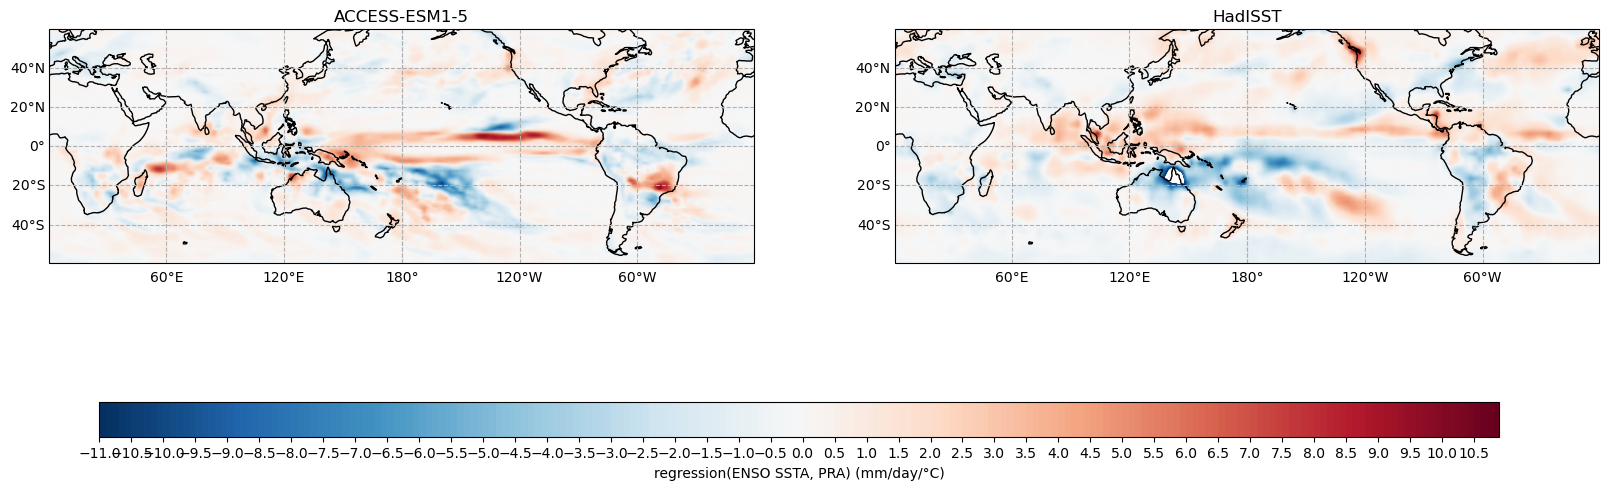

In [14]:
import iris.plot as iplt
import matplotlib.colors as mcolors
import cartopy.feature as cfeature
import cartopy.crs as ccrs

fig = plt.figure(figsize=(20, 7))
proj = ccrs.PlateCarree(central_longitude=180)

i =121

for label, cube in process.items():
    
    ax1 = plt.subplot(i,projection=proj)
    ax1.coastlines()
    cf1 = iplt.contourf(cube, levels=np.arange(-11,11,0.1), cmap='RdBu_r')
    ax1.set_title(label)
    gl1 = ax1.gridlines(draw_labels=True, linestyle='--')
    gl1.top_labels = False
    gl1.right_labels = False
    i+=1

# Add a single colorbar at the bottom
cax = plt.axes([0.15,0.08,0.7,0.05])
cbar = fig.colorbar(cf1, cax=cax, orientation='horizontal', extend='both', ticks=np.arange(-11,11.5,0.5))
cbar.set_label('regression(ENSO SSTA, PRA) (mm/day/°C)')